In [15]:
import gym
import numpy as np 
import matplotlib.pyplot as plt
import time

env = gym.make('CartPole-v1')
print(env.observation_space.low,"\n",env.observation_space.high)

[-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38] 
 [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38]


/opt/homebrew/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:97: UserWarning: WARN: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  logger.warn(


In [16]:
action_space = 2 # number of possible actions
bin_size = 15

overe0 = float(4)
overe1 = float(4)/2**1
overe2 = float(4)/2**2
overe3 = float(4)/2**3
overe4 = float(4)/2**4
overe5 = float(4)/2**5
overe6 = float(4)/2**6

lin_space = [-overe0, -overe1, -overe2, -overe3, -overe4, -overe5, -overe6, 0, overe6, overe5, overe4, overe3, overe2, overe1, overe0]

def Qtable(state_space,action_space,bin_size=15 ):
    bins = [np.linspace(-2.4,2.4,bin_size),
            lin_space,
            np.linspace(-0.2095,0.2095,bin_size),
            lin_space]
   
    q_table = np.random.uniform(low=-1,high=1,size=([len(bins[0]), len(bins[1]), len(bins[2]), len(bins[3])] + [action_space]))
    return q_table, bins

def Discrete(state, bins):
    index = []
    for i in range(len(state)): index.append(np.digitize(state[i],bins[i]) - 1)
    return tuple(index)

def epsilon_greedy_policy(state, Q, epsilon=0.1):
    explore = np.random.binomial(1, epsilon)
    if explore:
        action = env.action_space.sample()
    else:
        action = np.argmax(Q[state])
   
    return action

def plotLearning(data, episodes, timestep):
    ep = [i for i in range(0,episodes,timestep)]
    plt.plot(ep, data['max'], label = 'Max')
    plt.plot(ep, data['avg'], label = 'Avg')
    plt.plot(ep, data['min'], label = 'Min')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.legend(loc = "upper left")

def printImprovement (data, episode, rewards, timestep, runs, episodes_to_solve, process_time, timesWon, epsilon, solved):
    print('Episode : {} | Avg. Rewards -> {} | Max reward : {} | Min Reward : {}'.format(episode,rewards/timestep, max(runs), min(runs)))
    data['max'].append(max(runs))
    data['avg'].append(rewards/timestep)
    data['min'].append(min(runs))
    episodes_to_solve = episode
    if rewards/timestep >= 475:
        timesWon += 1 
        print('Solved in episode : {}'.format(episode))
        solved['episodes'].append(episode)
        solved['timeMinutes'].append(round((time.time() - process_time)/60,2))
        epsilon = 0.01
    
    return episodes_to_solve, timesWon, epsilon

def updateQtable(action, reward, current_state, next_state, gamma, lr):
    max_future_q = np.max(q_table[next_state])
    current_q = q_table[current_state+(action,)]
    new_q = (1-lr)*current_q + lr*(reward + gamma*max_future_q)
    q_table[current_state+(action,)] = new_q

In [17]:
    
def Q_learning(q_table, bins, episodes = 5000, gamma = 0.995, lr = 0.1, timestep = 5000, epsilon = 0.05):
    rewards, timesWon, episodes_to_solve = 0, 0, 0
    runs = []
    data = {'max' : [], 'avg' : [], 'min': []}
    solved = {'episodes' : [], 'timeMinutes': []}
    process_time = time.time()

    for episode in range(1,episodes+1):
        current_state = Discrete(env.reset(),bins) # initial observation
        score = 0
        done = False
        
        while not done:  
            action = epsilon_greedy_policy(current_state, q_table, epsilon)
            obs, reward, done, info = env.step(action)
            next_state = Discrete(obs,bins)
            score += reward
            
            updateQtable(action, reward, current_state,next_state, gamma, lr)           

            current_state = next_state
            
        # End of the loop update
        else:
            env.reset()
            rewards += score
            runs.append(score)
        
        # Timestep value update
        if episode%timestep == 0:
            episodes_to_solve, timesWon, epsilon = printImprovement(data, episode, rewards, timestep, runs, episodes_to_solve, process_time, timesWon, epsilon, solved)
            rewards, runs= 0, []
        
        if timesWon == 5:
            episodes_to_solve = episode
            break

    print('Solved ' + str(timesWon) + ' times in ' + str(solved))
    plotLearning(data, episodes_to_solve, timestep)
    env.close()

Episode : 1000 | Avg. Rewards -> 27.635 | Max reward : 116.0 | Min Reward : 9.0
Episode : 2000 | Avg. Rewards -> 31.159 | Max reward : 113.0 | Min Reward : 9.0
Episode : 3000 | Avg. Rewards -> 34.423 | Max reward : 125.0 | Min Reward : 10.0
Episode : 4000 | Avg. Rewards -> 41.028 | Max reward : 134.0 | Min Reward : 10.0
Episode : 5000 | Avg. Rewards -> 46.378 | Max reward : 146.0 | Min Reward : 10.0
Episode : 6000 | Avg. Rewards -> 51.334 | Max reward : 202.0 | Min Reward : 10.0
Episode : 7000 | Avg. Rewards -> 61.844 | Max reward : 282.0 | Min Reward : 10.0
Episode : 8000 | Avg. Rewards -> 88.712 | Max reward : 500.0 | Min Reward : 9.0
Episode : 9000 | Avg. Rewards -> 128.224 | Max reward : 500.0 | Min Reward : 22.0
Episode : 10000 | Avg. Rewards -> 145.098 | Max reward : 500.0 | Min Reward : 22.0
Episode : 11000 | Avg. Rewards -> 164.329 | Max reward : 500.0 | Min Reward : 19.0
Episode : 12000 | Avg. Rewards -> 218.548 | Max reward : 500.0 | Min Reward : 23.0
Episode : 13000 | Avg. R

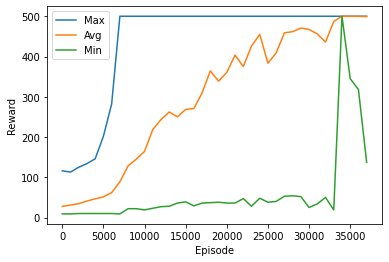

In [14]:
# TRANING
q_table, bins = Qtable(len(env.observation_space.low), env.action_space.n)
Q_learning(q_table, bins, lr = 0.14, gamma = 0.995, episodes = 5*10**4, timestep = 1000, epsilon = 0.06)